In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.optimize import minimize

# Generate synthetic data (replace with your dataset)
np.random.seed(0)
X = np.random.rand(100, 5)
y = X @ np.array([2, -3, 5, -1, 4]) + np.random.randn(100) * 0.5  # Add some noise

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the constrained Lasso objective
def constrained_lasso(params, X, y, alpha):
    intercept = params[0]
    coef = params[1:]
    predictions = intercept + np.dot(X, coef)
    mse = mean_squared_error(y, predictions)
    lasso_penalty = alpha * np.sum(np.abs(coef))
    return mse + lasso_penalty

# Set the regularization strength
alpha = 0.1

# Initial guess for parameters: intercept + coefficients
initial_params = np.zeros(X_train.shape[1] + 1)  # intercept + coefficients

# Bounds for parameters: intercept is unconstrained, coefficients are constrained between -15 and 15
bounds = [(None, None)] + [(-15, 15)] * X_train.shape[1]

# Fit the constrained Lasso model
result = minimize(constrained_lasso, initial_params, args=(X_train, y_train, alpha), bounds=bounds)
intercept_constrained, coefficients_constrained = result.x[0], result.x[1:]

# Make predictions with the constrained model
y_pred_constrained = intercept_constrained + np.dot(X_test, coefficients_constrained)

# Fit the unconstrained Lasso model
lasso_unconstrained = Lasso(alpha=alpha).fit(X_train, y_train)
y_pred_unconstrained = lasso_unconstrained.predict(X_test)

# Calculate performance metrics for both models
def evaluate_performance(y_true, y_pred, model_name="Model"):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} Performance:")
    print(f"  Mean Squared Error (MSE): {mse:.4f}")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  R^2 Score: {r2:.4f}")
    print("")

# Evaluate performance of constrained Lasso
evaluate_performance(y_test, y_pred_constrained, model_name="Constrained Lasso")

# Evaluate performance of unconstrained Lasso
evaluate_performance(y_test, y_pred_unconstrained, model_name="Unconstrained Lasso")

# Optionally, print the coefficients to compare
print("Constrained Lasso Coefficients:", coefficients_constrained)
print("Unconstrained Lasso Coefficients:", lasso_unconstrained.coef_)


Constrained Lasso Performance:
  Mean Squared Error (MSE): 0.3965
  Mean Absolute Error (MAE): 0.5104
  R^2 Score: 0.9374

Unconstrained Lasso Performance:
  Mean Squared Error (MSE): 0.9885
  Mean Absolute Error (MAE): 0.8365
  R^2 Score: 0.8440

Constrained Lasso Coefficients: [ 1.3048642  -2.45105205  4.897793   -0.6455098   3.31511516]
Unconstrained Lasso Coefficients: [ 0.54016566 -1.77849267  4.50399602 -0.01051208  2.50919104]


In [ ]:
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Sample data (replace with your own dataset)
import numpy as np
np.random.seed(0)
X = np.random.rand(100, 5)
y = X @ np.array([2, -3, 5, -1, 4]) + np.random.randn(100) * 0.5  # Adding some noise

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define a range of alpha values to test (log scale)
alpha_values = np.logspace(-5, 2, 100)  # from 10^-5 to 10^2

# Perform LassoCV to find the best alpha
lasso_cv = LassoCV(alphas=alpha_values, cv=5, random_state=0).fit(X_train, y_train)

# Optimal alpha found
optimal_alpha = lasso_cv.alpha_
print(f"Optimal alpha: {optimal_alpha}")

# Evaluate the model with the optimal alpha on the test set
y_pred = lasso_cv.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on Test Set: {mse:.4f}")


Optimal alpha: 0.0015556761439304723
Mean Squared Error on Test Set: 0.3871


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# Generate synthetic data (replace with your own data)
np.random.seed(0)
X = np.random.rand(100, 5)
y = X @ np.array([2, -3, 5, -1, 4]) + np.random.randn(100) * 0.5  # Adding some noise

# Define a range of alpha values to test
alpha_values = np.logspace(-5, 2, 100)  # Adjust as needed for finer granularity

# Define bounds for each coefficient (e.g., -15 to 15)
bounds = [(None, None)] + [(-15, 15)] * X.shape[1]  # First entry for intercept

# Function to fit constrained Lasso for a given alpha
def constrained_lasso(params, X, y, alpha):
    intercept = params[0]
    coef = params[1:]
    predictions = intercept + np.dot(X, coef)
    mse = mean_squared_error(y, predictions)
    lasso_penalty = alpha * np.sum(np.abs(coef))
    return mse + lasso_penalty

# Cross-validation function for constrained Lasso
def cross_val_constrained_lasso(X, y, alpha, bounds, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    errors = []

    for train_index, val_index in kf.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]

        # Initial parameters for minimize (intercept + coefficients)
        initial_params = np.zeros(X_train.shape[1] + 1)

        # Fit the constrained model
        result = minimize(constrained_lasso, initial_params, args=(X_train, y_train, alpha), bounds=bounds)

        # Predict on validation set
        intercept, coef = result.x[0], result.x[1:]
        y_pred = intercept + np.dot(X_val, coef)

        # Calculate MSE for this fold and store it
        errors.append(mean_squared_error(y_val, y_pred))

    # Return the average MSE across folds
    return np.mean(errors)

# Perform cross-validation for each alpha value
alpha_errors = {}
for alpha in alpha_values:
    avg_error = cross_val_constrained_lasso(X, y, alpha, bounds, n_splits=5)
    alpha_errors[alpha] = avg_error
    #print(f"Alpha: {alpha:.5f} - CV MSE: {avg_error:.4f}")

# Find the best alpha with the lowest average cross-validated MSE
optimal_alpha = min(alpha_errors, key=alpha_errors.get)
print(f"Optimal alpha: {optimal_alpha}")


Optimal alpha: 0.0093260334688322


In [ ]:
#This code compares the performance of two feature selection methods—backward elimination and Lasso regression with cross-validation—on
#synthetic datasets over multiple trials. Each dataset is generated to include a mix of relevant and irrelevant predictors, with added noise.
#The goal is to evaluate how well each method identifies relevant predictors and generalizes to unseen data.

In [115]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

# Parameters for synthetic data generation
num_samples = 100  # Number of samples in each dataset
num_predictors = 10  # 10 # Total number of predictors
num_relevant_predictors = 5 # 5  # Number of truly relevant predictors
noise_level = 0.5  # Noise level to add to the response variable
num_trials = 50  # Number of regression tasks to simulate


# Function to generate synthetic data
def generate_data(num_samples, num_predictors, num_relevant, noise_level):
    X = np.random.randn(num_samples, num_predictors)
    true_coefficients = np.zeros(num_predictors)
    true_coefficients[:num_relevant] = np.random.uniform(1, 5, size=num_relevant)
    y = X @ true_coefficients + np.random.normal(0, noise_level, size=num_samples)
    return X, y, true_coefficients


def backward_elimination(X, y, significance_level=0.05):
    X = sm.add_constant(X)  # Add intercept
    while True:
        model = sm.OLS(y, X).fit()
        pvalues = model.pvalues.drop('const')  # Exclude intercept
        max_p_value = pvalues.max()
        if max_p_value > significance_level:
            excluded_feature = pvalues.idxmax()
            X = X.drop(columns=[excluded_feature])
        else:
            break
        if X.shape[1] == 1:  # Only 'const' remains
            break
    return model, X.columns  # Return model and remaining columns


# Function to evaluate performance on a test set
def evaluate_performance(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))  # Calculate adjusted R^2
    return mse, r2, adj_r2

# Main loop to perform multiple trials and average performance
backward_results = []
lasso_results = []
backward_predictor_counts = []
lasso_predictor_counts = []

for _ in range(num_trials):
    # Generate synthetic dataset
    X, y, true_coefficients = generate_data(num_samples, num_predictors, num_relevant_predictors, noise_level)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Backward Elimination
    X_train_df = pd.DataFrame(X_train, columns=[f'X{i}' for i in range(X_train.shape[1])])
    X_test_df = pd.DataFrame(X_test, columns=[f'X{i}' for i in range(X_test.shape[1])])
    model, remaining_columns = backward_elimination(X_train_df, y_train)

    # Count remaining predictors after backward elimination (excluding intercept)
    num_predictors_backward = len(remaining_columns) - 1
    backward_predictor_counts.append(num_predictors_backward)

    # Select the same columns in the test set as in the model
    X_test_reduced = sm.add_constant(X_test_df[remaining_columns[1:]])  # Skip the intercept column
    y_pred_backward = model.predict(X_test_reduced)
    mse_backward, r2_backward, adj_r2_backward = evaluate_performance(y_test, y_pred_backward, n=len(y_test), p=num_predictors_backward)
    backward_results.append((mse_backward, r2_backward, adj_r2_backward))

    # Lasso with Cross-Validation
    lasso = LassoCV(alphas=np.logspace(-7, 1, 100), cv=5, random_state=0).fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    num_predictors_lasso = np.sum(lasso.coef_ != 0)
    lasso_predictor_counts.append(num_predictors_lasso)
    mse_lasso, r2_lasso, adj_r2_lasso = evaluate_performance(y_test, y_pred_lasso, n=len(y_test), p=num_predictors_lasso)
    lasso_results.append((mse_lasso, r2_lasso, adj_r2_lasso))

# Calculate average performance over all trials
backward_mse_avg = np.mean([result[0] for result in backward_results])
backward_r2_avg = np.mean([result[1] for result in backward_results])
backward_adj_r2_avg = np.mean([result[2] for result in backward_results])

lasso_mse_avg = np.mean([result[0] for result in lasso_results])
lasso_r2_avg = np.mean([result[1] for result in lasso_results])
lasso_adj_r2_avg = np.mean([result[2] for result in lasso_results])

# Calculate average number of predictors remaining
backward_avg_predictors = np.mean(backward_predictor_counts)
lasso_avg_predictors = np.mean(lasso_predictor_counts)

print("Average Performance over Trials:")
print(f"Backward Elimination - MSE: {backward_mse_avg:.4f}, R^2: {backward_r2_avg:.4f}, Adjusted R^2: {backward_adj_r2_avg:.4f}")
print(f"Lasso - MSE: {lasso_mse_avg:.4f}, R^2: {lasso_r2_avg:.4f}, Adjusted R^2: {lasso_adj_r2_avg:.4f}")

print("\nAverage Number of Predictors Remaining:")
print(f"Backward Elimination: {backward_avg_predictors:.2f} predictors")
print(f"Lasso: {lasso_avg_predictors:.2f} predictors")


Average Performance over Trials:
Backward Elimination - MSE: 0.3091, R^2: 0.9939, Adjusted R^2: 0.9925
Lasso - MSE: 0.3241, R^2: 0.9936, Adjusted R^2: 0.9911

Average Number of Predictors Remaining:
Backward Elimination: 5.20 predictors
Lasso: 8.02 predictors


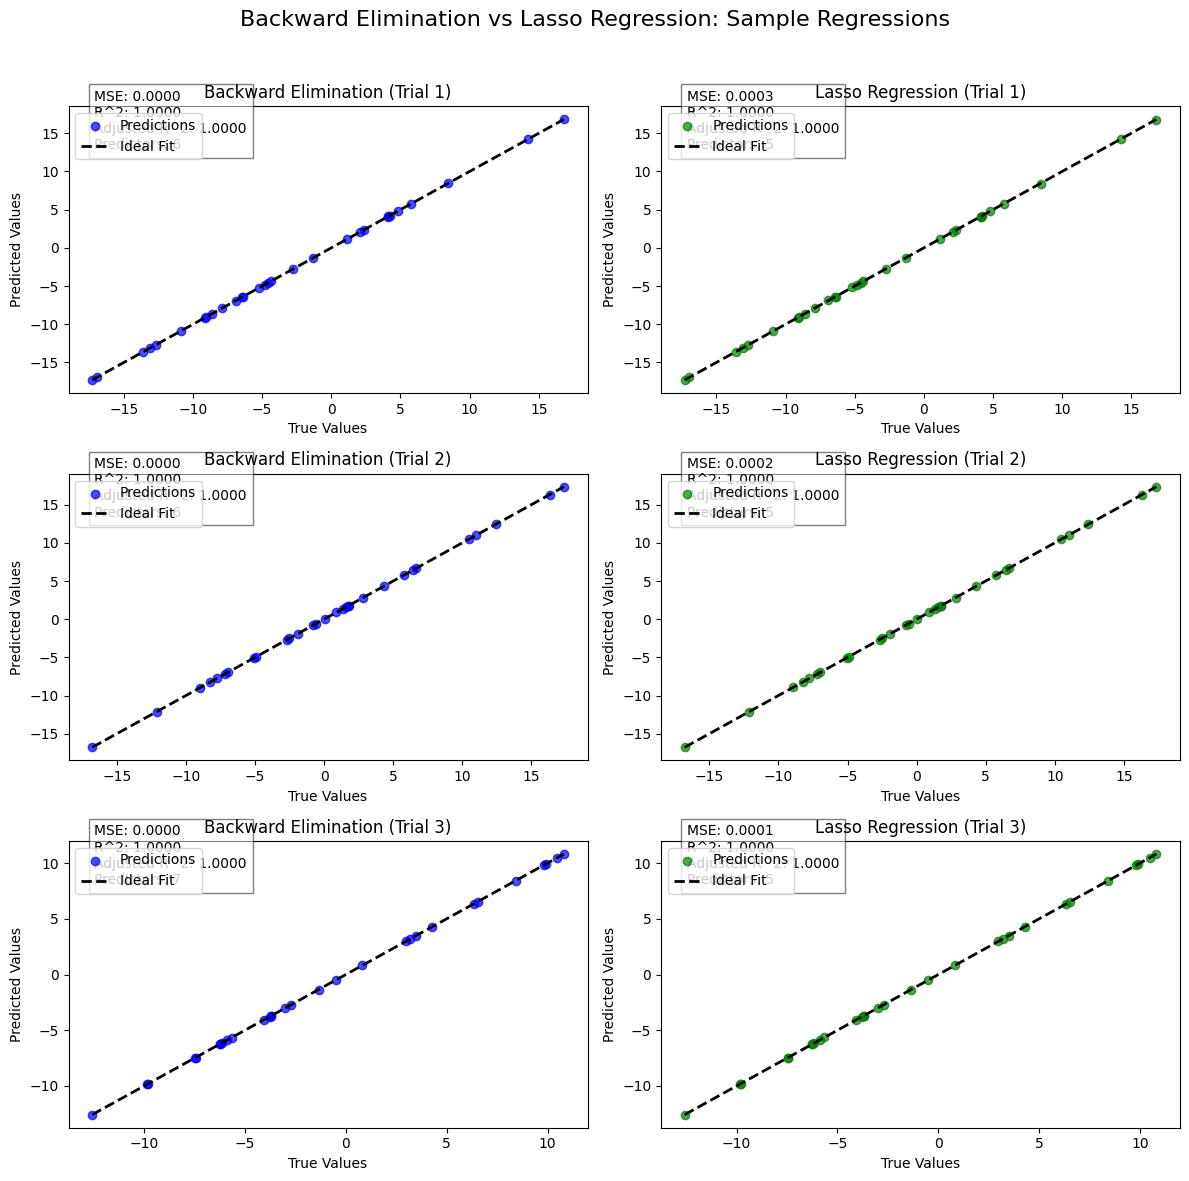

In [96]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

# Parameters for synthetic data generation
num_samples = 100  # Number of samples in each dataset
num_predictors = 10  # Total number of predictors
num_relevant_predictors = 5  # Number of truly relevant predictors
noise_level = 0.0  # Noise level to add to the response variable
num_trials = 3  # Number of regression tasks to visualize (set to 3 for plotting)

# Function to generate synthetic data
def generate_data(num_samples, num_predictors, num_relevant, noise_level):
    X = np.random.randn(num_samples, num_predictors)
    true_coefficients = np.zeros(num_predictors)
    true_coefficients[:num_relevant] = np.random.uniform(1, 5, size=num_relevant)
    y = X @ true_coefficients + np.random.normal(0, noise_level, size=num_samples)
    return X, y, true_coefficients

# Function for backward elimination
def backward_elimination(X, y, significance_level=0.05):
    X = sm.add_constant(X)  # Add intercept
    while True:
        model = sm.OLS(y, X).fit()
        pvalues = model.pvalues.drop('const')  # Exclude intercept
        max_p_value = pvalues.max()
        if max_p_value > significance_level:
            excluded_feature = pvalues.idxmax()
            X = X.drop(columns=[excluded_feature])
        else:
            break
        if X.shape[1] == 1:  # Only 'const' remains
            break
    return model, X.columns  # Return model and remaining columns


# Function to evaluate performance on a test set
def evaluate_performance(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))  # Calculate adjusted R^2
    return mse, r2, adj_r2

# Main loop to visualize three sample regressions
fig, axes = plt.subplots(num_trials, 2, figsize=(12, 12))
fig.suptitle("Backward Elimination vs Lasso Regression: Sample Regressions", fontsize=16)

for i in range(num_trials):
    # Generate synthetic dataset
    X, y, true_coefficients = generate_data(num_samples, num_predictors, num_relevant_predictors, noise_level)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Backward Elimination
    X_train_df = pd.DataFrame(X_train, columns=[f'X{i}' for i in range(X_train.shape[1])])
    X_test_df = pd.DataFrame(X_test, columns=[f'X{i}' for i in range(X_test.shape[1])])
    model, remaining_columns = backward_elimination(X_train_df, y_train)

    # Select the same columns in the test set as in the model
    X_test_reduced = sm.add_constant(X_test_df[remaining_columns[1:]])  # Skip the intercept column
    y_pred_backward = model.predict(X_test_reduced)
    mse_backward, r2_backward, adj_r2_backward = evaluate_performance(y_test, y_pred_backward, n=len(y_test), p=len(remaining_columns) - 1)

    # Lasso with Cross-Validation
    lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    mse_lasso, r2_lasso, adj_r2_lasso = evaluate_performance(y_test, y_pred_lasso, n=len(y_test), p=np.sum(lasso.coef_ != 0))

    # Plot results for backward elimination
    ax_backward = axes[i, 0]
    ax_backward.scatter(y_test, y_pred_backward, alpha=0.7, color="blue", label="Predictions")
    ax_backward.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal Fit")
    ax_backward.set_title(f"Backward Elimination (Trial {i+1})")
    ax_backward.set_xlabel("True Values")
    ax_backward.set_ylabel("Predicted Values")
    ax_backward.legend()
    ax_backward.text(0.05, 0.85, f"MSE: {mse_backward:.4f}\nR^2: {r2_backward:.4f}\nAdjusted R^2: {adj_r2_backward:.4f}\nPredictors: {len(remaining_columns) - 1}",
                     transform=ax_backward.transAxes, fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

    # Plot results for Lasso
    ax_lasso = axes[i, 1]
    ax_lasso.scatter(y_test, y_pred_lasso, alpha=0.7, color="green", label="Predictions")
    ax_lasso.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label="Ideal Fit")
    ax_lasso.set_title(f"Lasso Regression (Trial {i+1})")
    ax_lasso.set_xlabel("True Values")
    ax_lasso.set_ylabel("Predicted Values")
    ax_lasso.legend()
    ax_lasso.text(0.05, 0.85, f"MSE: {mse_lasso:.4f}\nR^2: {r2_lasso:.4f}\nAdjusted R^2: {adj_r2_lasso:.4f}\nPredictors: {np.sum(lasso.coef_ != 0)}",
                  transform=ax_lasso.transAxes, fontsize=10, bbox=dict(facecolor="white", alpha=0.5))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.303e+00, tolerance: 1.028e+00
  model = cd_fast.enet_coordinate_descent(
<ipython-input-122-de629bf99ed5>:143: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


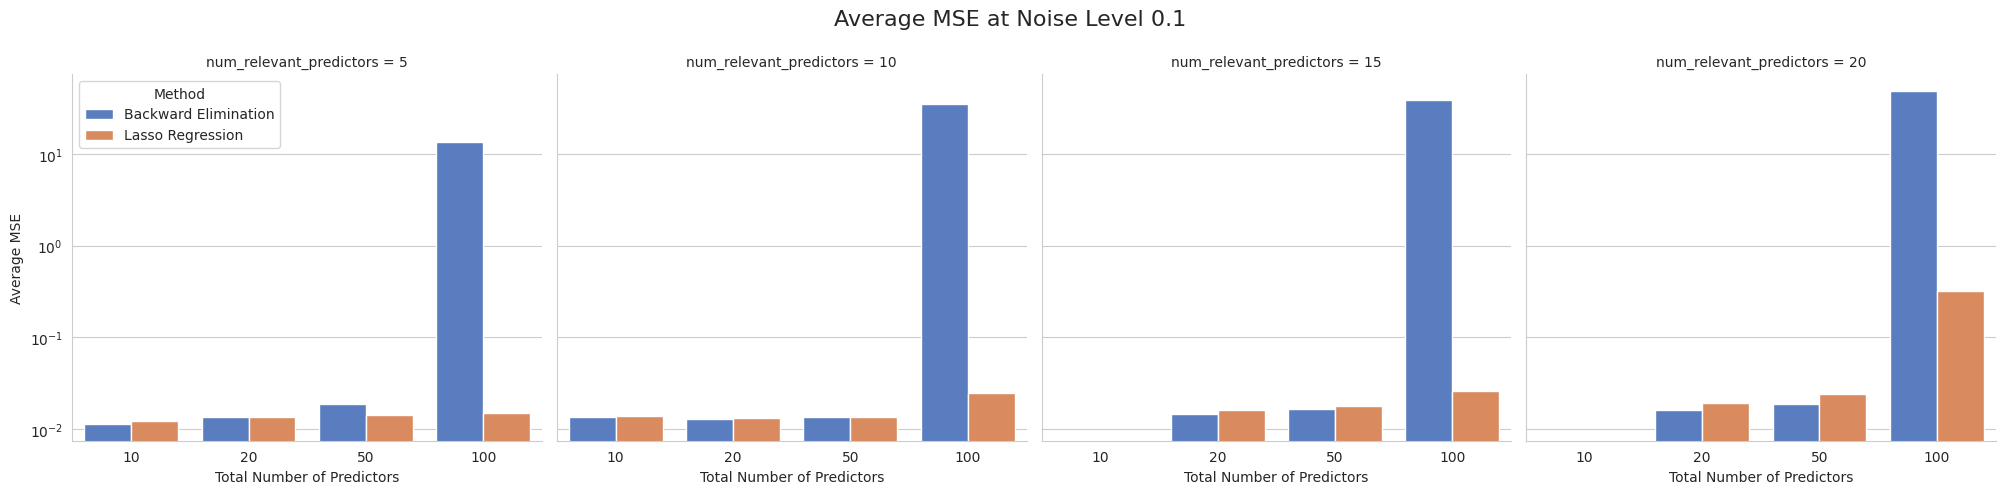

<ipython-input-122-de629bf99ed5>:143: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


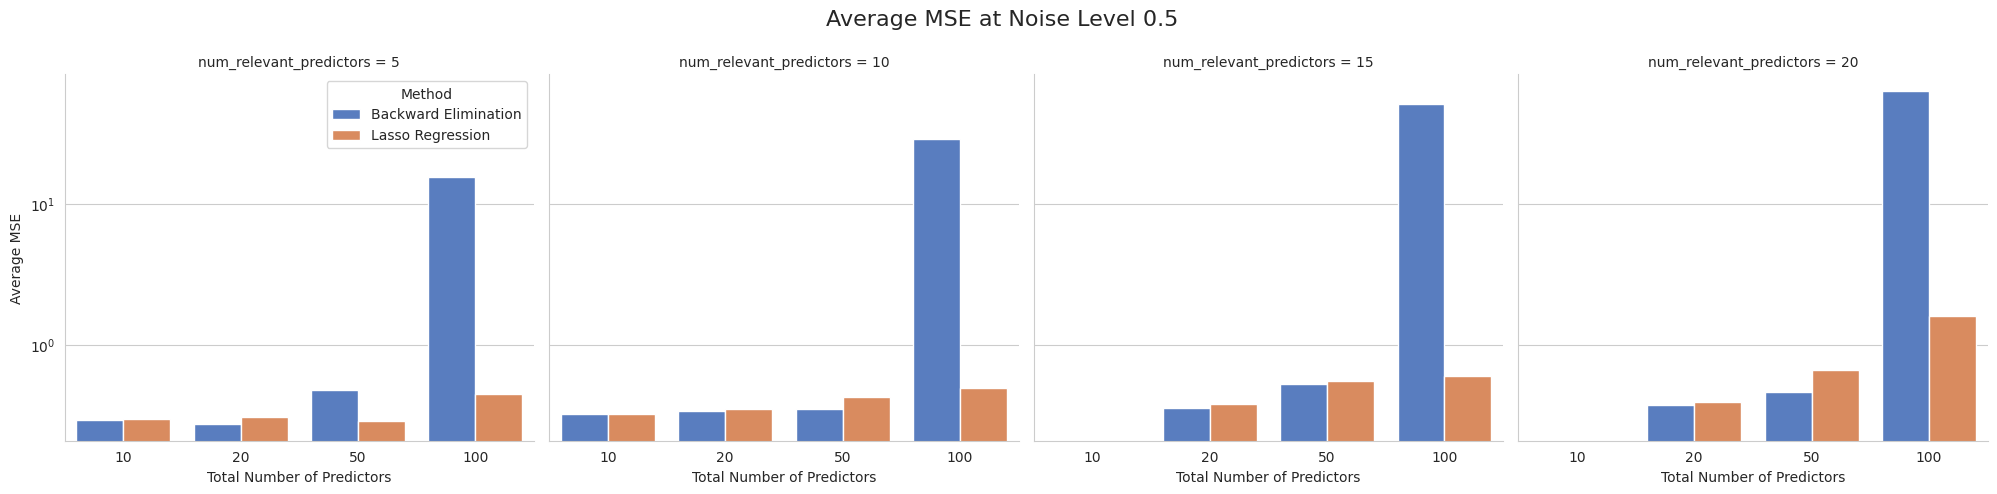

<ipython-input-122-de629bf99ed5>:143: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


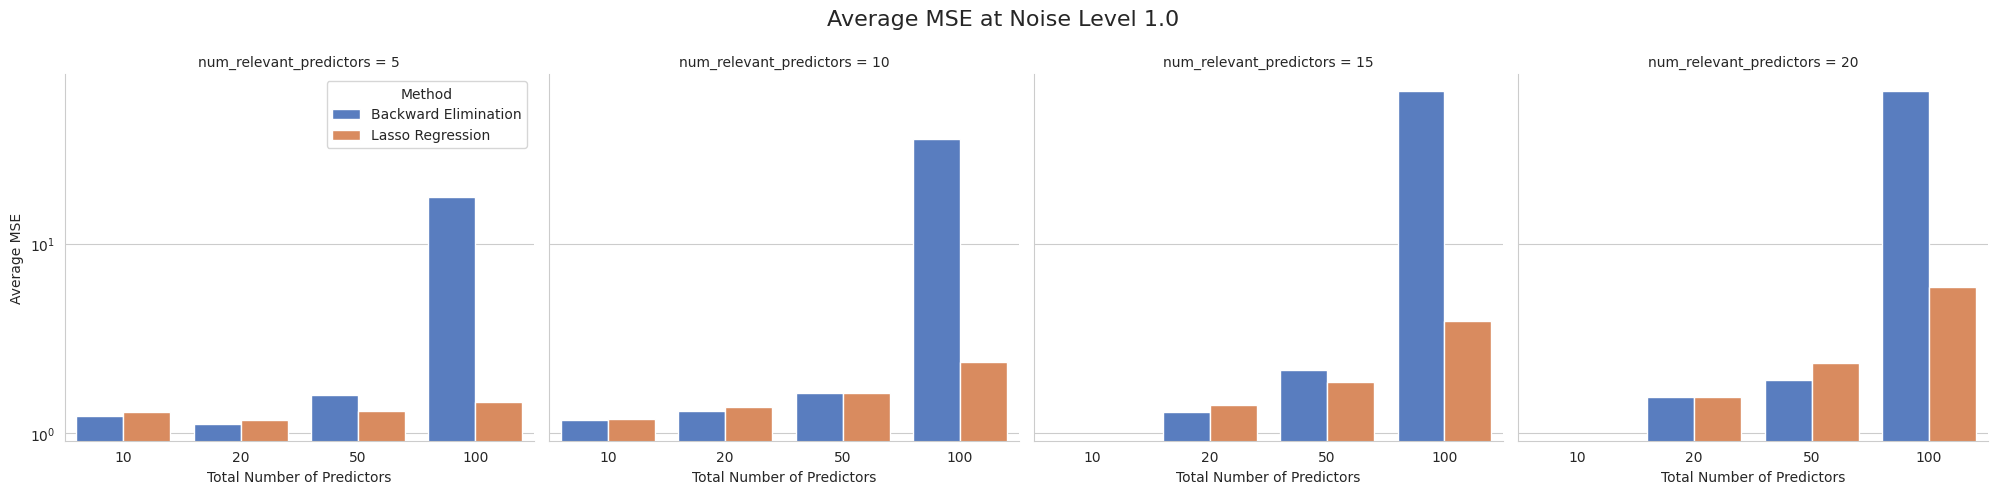

<ipython-input-122-de629bf99ed5>:159: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


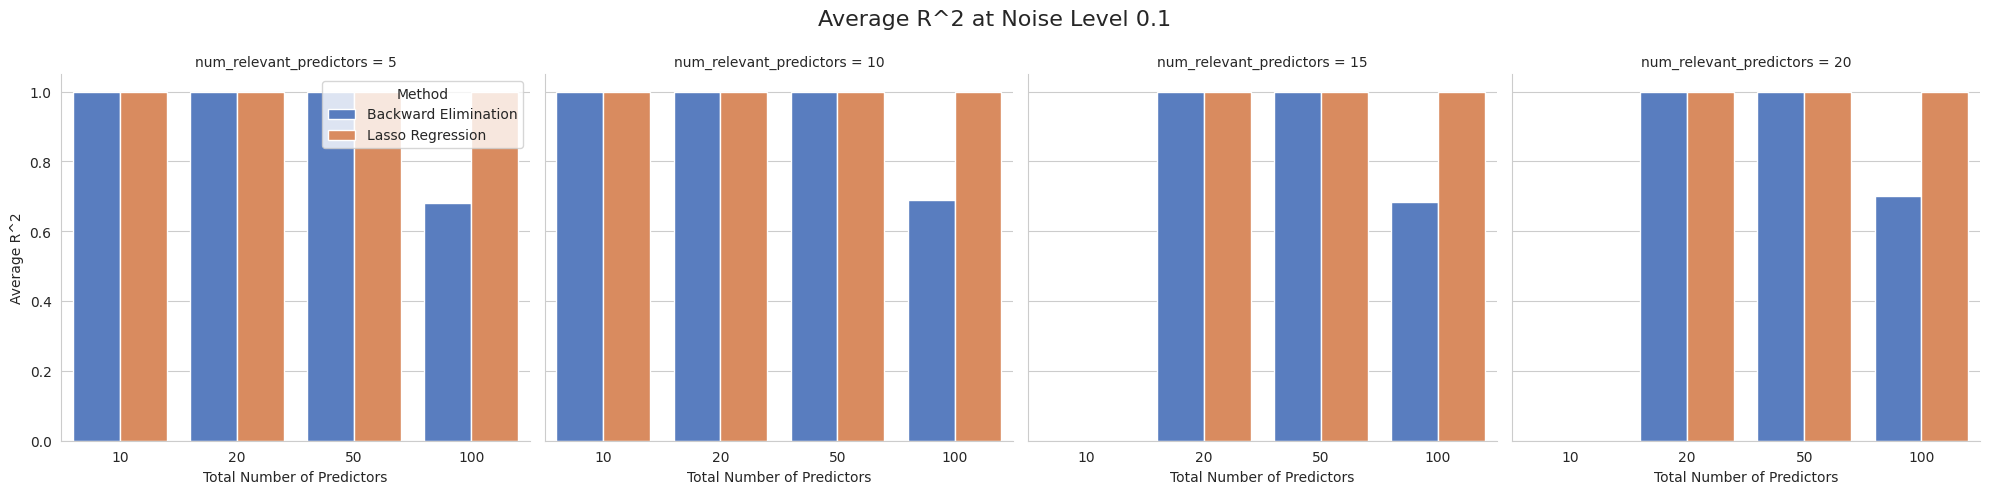

<ipython-input-122-de629bf99ed5>:159: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


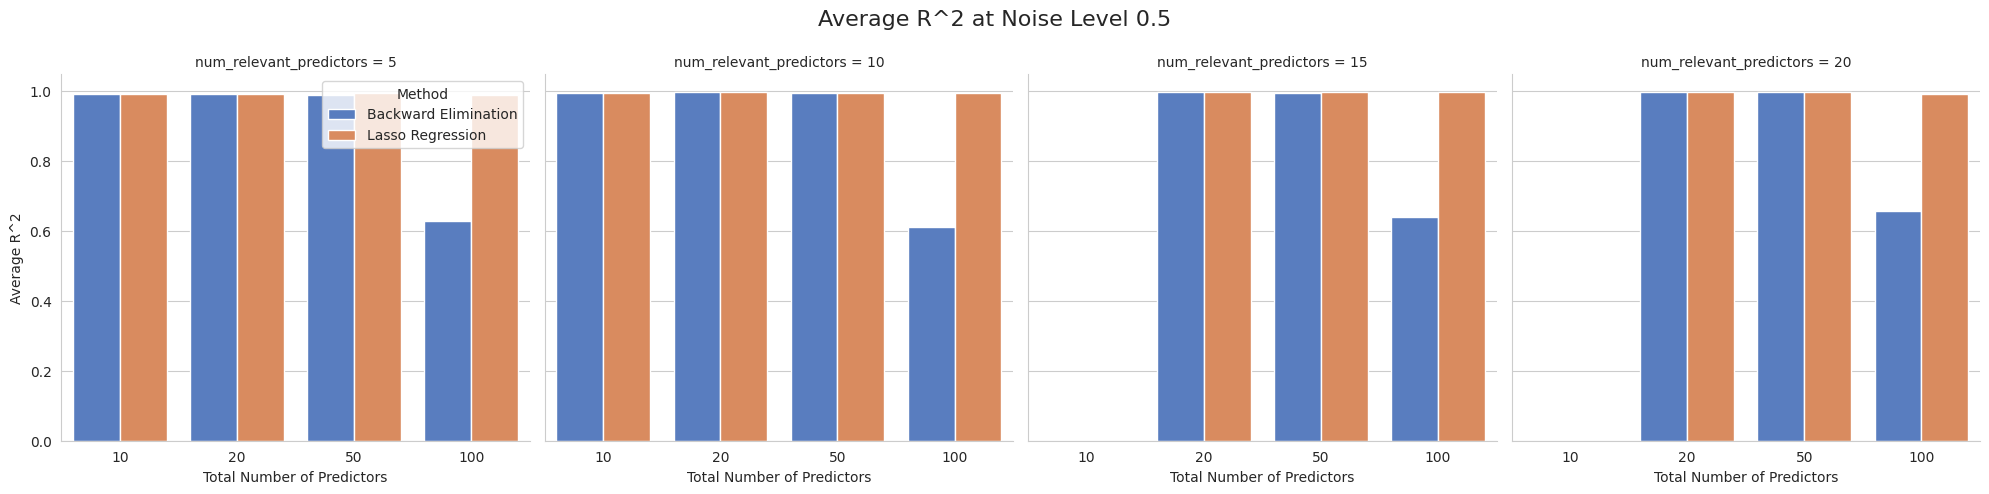

<ipython-input-122-de629bf99ed5>:159: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


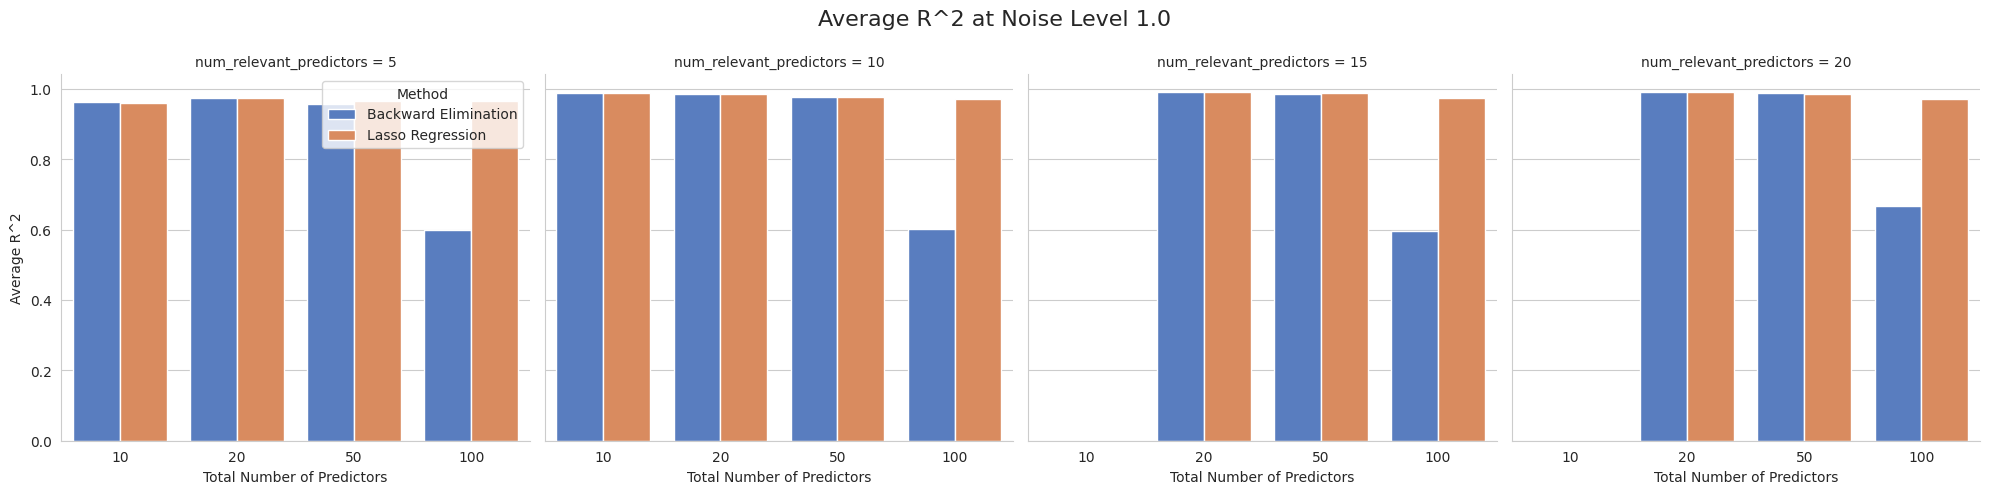

<ipython-input-122-de629bf99ed5>:174: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


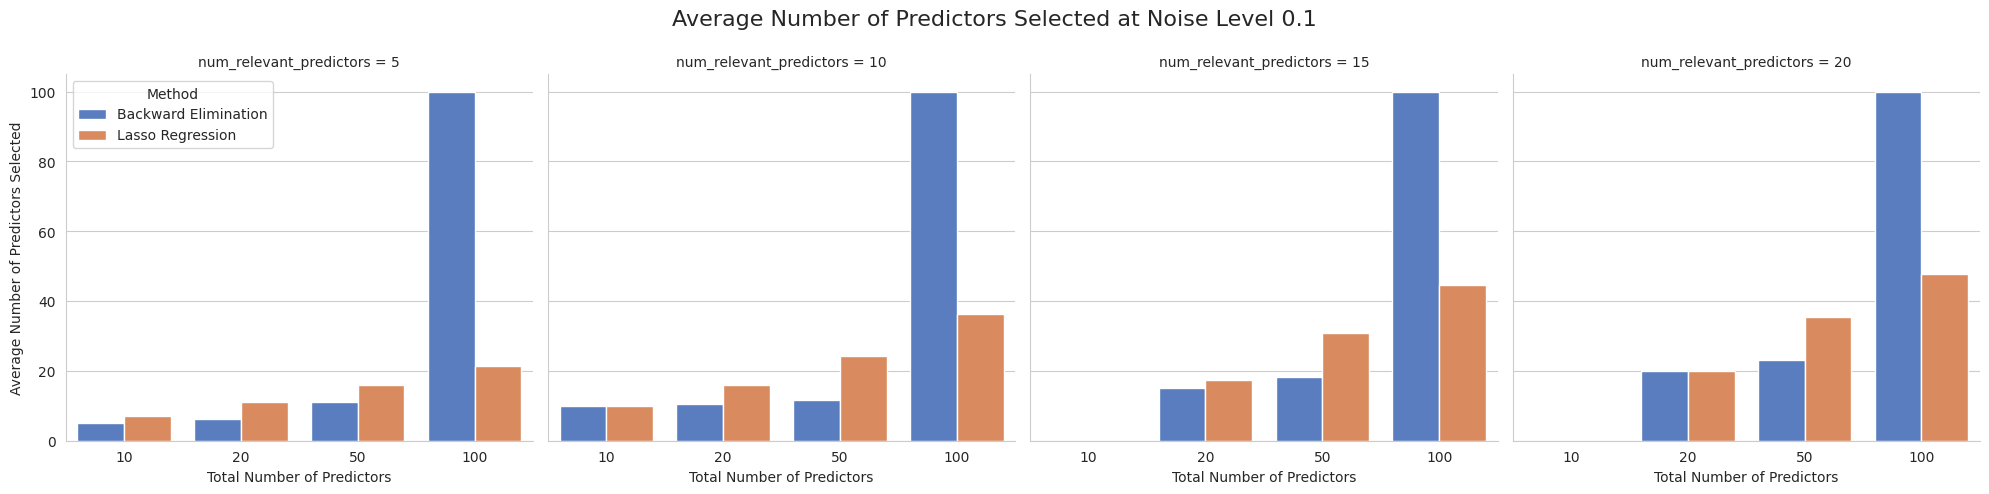

<ipython-input-122-de629bf99ed5>:174: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


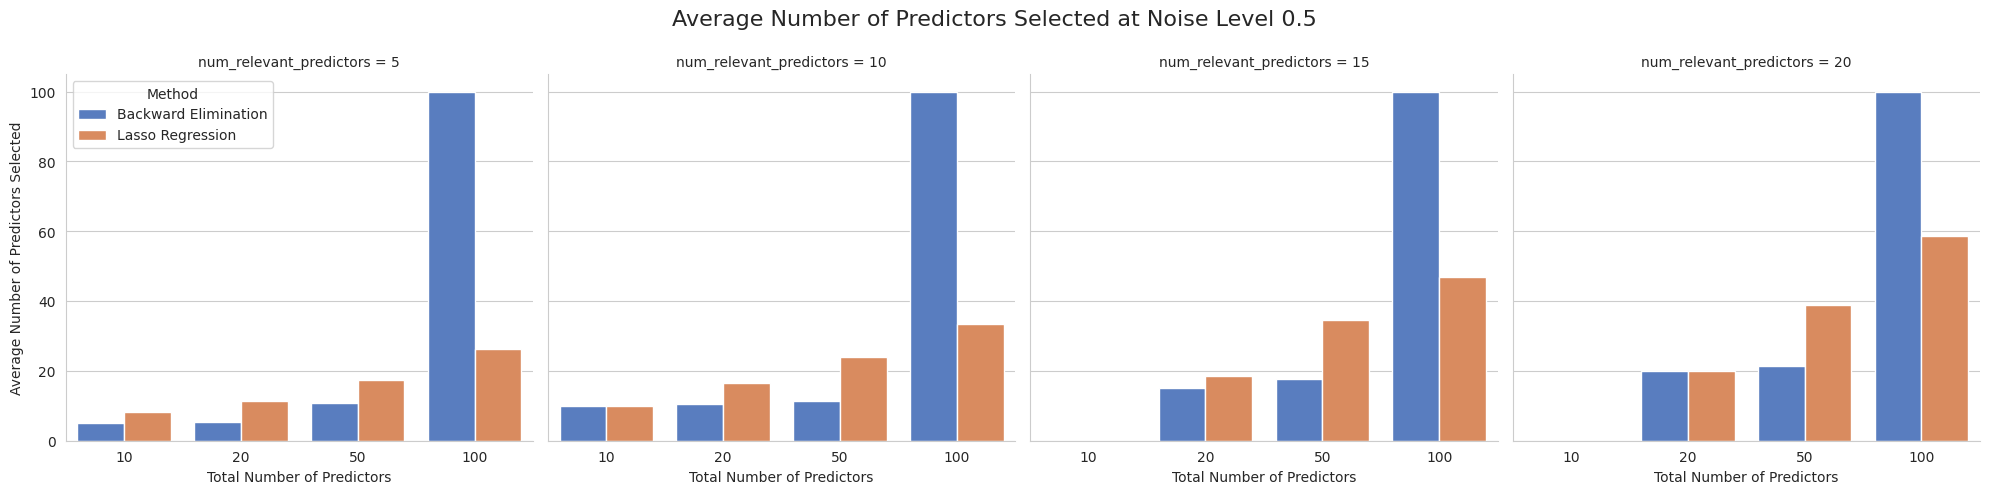

<ipython-input-122-de629bf99ed5>:174: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  g = sns.catplot(


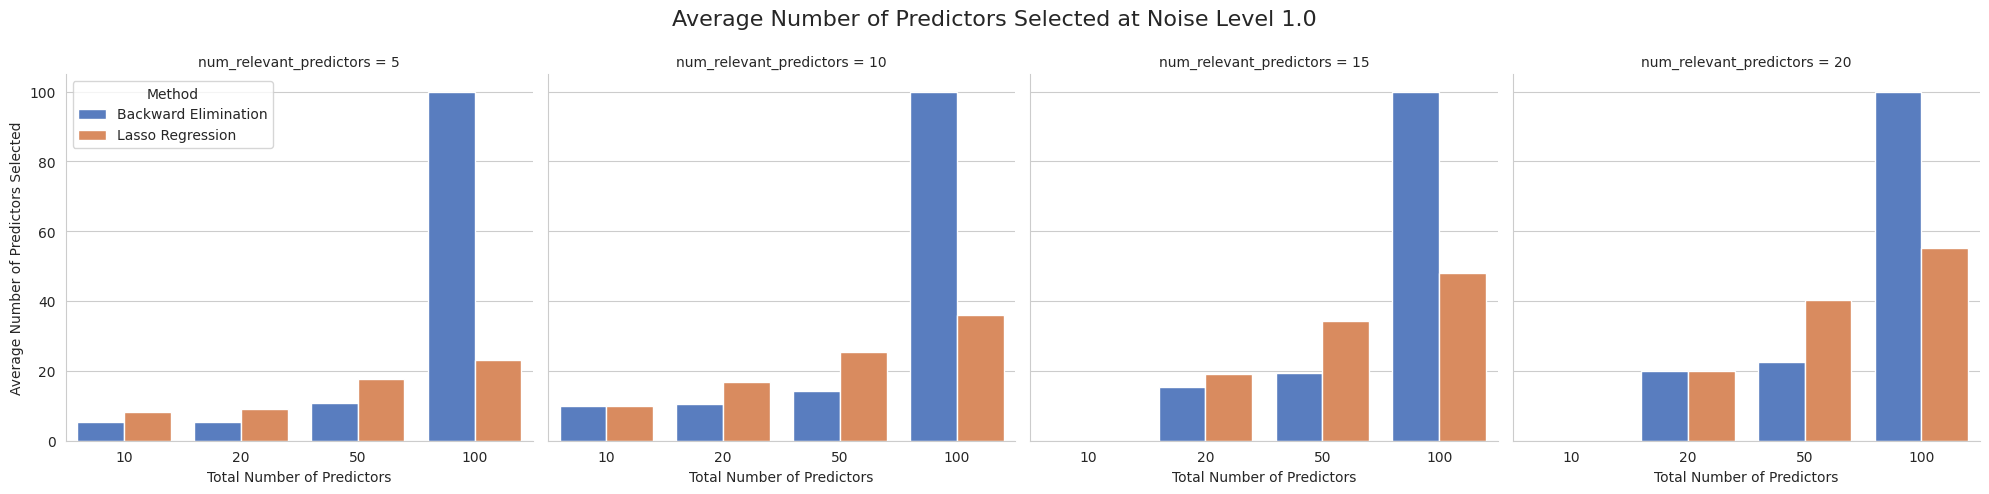

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

# Function to generate synthetic data
def generate_data(num_samples, num_predictors, num_relevant, noise_level):
    X = np.random.randn(num_samples, num_predictors)
    true_coefficients = np.zeros(num_predictors)
    # Randomly select indices for relevant predictors
    relevant_indices = np.random.choice(num_predictors, num_relevant, replace=False)
    true_coefficients[relevant_indices] = np.random.uniform(1, 5, size=num_relevant)
    y = X @ true_coefficients + np.random.normal(0, noise_level, size=num_samples)
    return X, y, true_coefficients

# Function for backward elimination
def backward_elimination(X, y, significance_level=0.05):
    X = sm.add_constant(X)  # Add intercept
    while True:
        model = sm.OLS(y, X).fit()
        pvalues = model.pvalues.drop('const')  # Exclude intercept
        if pvalues.empty:
            break
        max_p_value = pvalues.max()
        if max_p_value > significance_level:
            excluded_feature = pvalues.idxmax()
            X = X.drop(columns=[excluded_feature])
        else:
            break
        if X.shape[1] == 1:  # Only 'const' remains
            break
    return model, X.columns  # Return model and remaining columns

# Function to evaluate performance on a test set
def evaluate_performance(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    if p >= n - 1:
        adj_r2 = np.nan  # Adjusted R^2 is not defined when p >= n - 1
    else:
        adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))  # Calculate adjusted R^2
    return mse, r2, adj_r2

# Parameters to vary
num_samples = 100  # Number of samples in each dataset
num_predictors_list = [10, 20, 50, 100]  # Different total numbers of predictors
num_relevant_predictors_list = [5, 10, 15, 20]  # Different numbers of relevant predictors
noise_levels = [0.1, 0.5, 1.0]  # Different noise levels
num_trials = 10  # Number of trials per parameter combination

# Initialize a list to store results
results = []

for num_predictors in num_predictors_list:
    for num_relevant_predictors in num_relevant_predictors_list:
        if num_relevant_predictors > num_predictors:
            continue  # Skip invalid configurations
        for noise_level in noise_levels:
            backward_mse_list = []
            backward_r2_list = []
            backward_num_predictors_list = []
            lasso_mse_list = []
            lasso_r2_list = []
            lasso_num_predictors_list = []
            for _ in range(num_trials):
                # Generate synthetic dataset
                X, y, true_coefficients = generate_data(
                    num_samples, num_predictors, num_relevant_predictors, noise_level)
                X_train, X_test, y_train, y_test = train_test_split(
                    X, y, test_size=0.3, random_state=None)

                # Backward Elimination
                X_train_df = pd.DataFrame(X_train, columns=[f'X{i}' for i in range(X_train.shape[1])])
                X_test_df = pd.DataFrame(X_test, columns=[f'X{i}' for i in range(X_test.shape[1])])
                model, remaining_columns = backward_elimination(X_train_df, y_train)

                # Number of predictors selected (excluding intercept)
                num_predictors_backward = len(remaining_columns) - 1
                backward_num_predictors_list.append(num_predictors_backward)

                # Handle case when no predictors remain (only intercept)
                if len(remaining_columns) > 1:
                    X_test_reduced = sm.add_constant(X_test_df[remaining_columns[1:]])  # Skip intercept
                else:
                    X_test_reduced = pd.DataFrame({'const': np.ones(len(X_test))})
                y_pred_backward = model.predict(X_test_reduced)
                mse_backward, r2_backward, _ = evaluate_performance(
                    y_test, y_pred_backward, n=len(y_test), p=num_predictors_backward)
                backward_mse_list.append(mse_backward)
                backward_r2_list.append(r2_backward)

                # Lasso Regression
                lasso = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
                y_pred_lasso = lasso.predict(X_test)
                num_predictors_lasso = np.sum(lasso.coef_ != 0)
                lasso_num_predictors_list.append(num_predictors_lasso)
                mse_lasso, r2_lasso, _ = evaluate_performance(
                    y_test, y_pred_lasso, n=len(y_test), p=num_predictors_lasso)
                lasso_mse_list.append(mse_lasso)
                lasso_r2_list.append(r2_lasso)

            # Compute average performance over trials
            avg_backward_mse = np.mean(backward_mse_list)
            avg_backward_r2 = np.mean(backward_r2_list)
            avg_backward_num_predictors = np.mean(backward_num_predictors_list)
            avg_lasso_mse = np.mean(lasso_mse_list)
            avg_lasso_r2 = np.mean(lasso_r2_list)
            avg_lasso_num_predictors = np.mean(lasso_num_predictors_list)

            # Store the results
            results.append({
                'num_predictors': num_predictors,
                'num_relevant_predictors': num_relevant_predictors,
                'noise_level': noise_level,
                'method': 'Backward Elimination',
                'avg_mse': avg_backward_mse,
                'avg_r2': avg_backward_r2,
                'avg_num_predictors': avg_backward_num_predictors
            })
            results.append({
                'num_predictors': num_predictors,
                'num_relevant_predictors': num_relevant_predictors,
                'noise_level': noise_level,
                'method': 'Lasso Regression',
                'avg_mse': avg_lasso_mse,
                'avg_r2': avg_lasso_r2,
                'avg_num_predictors': avg_lasso_num_predictors
            })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Visualization
sns.set_style('whitegrid')

# Plot Average MSE
for noise_level in noise_levels:
    subset = results_df[results_df['noise_level'] == noise_level]
    g = sns.catplot(
        data=subset, kind='bar',
        x='num_predictors', y='avg_mse', hue='method',
        col='num_relevant_predictors', ci='sd', palette='muted',
        legend_out=False
    )
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f'Average MSE at Noise Level {noise_level}', fontsize=16)
    g.set_axis_labels('Total Number of Predictors', 'Average MSE')
    g._legend.set_title('Method')
    g.set(yscale='log')
    plt.show()

# Plot Average R^2
for noise_level in noise_levels:
    subset = results_df[results_df['noise_level'] == noise_level]
    g = sns.catplot(
        data=subset, kind='bar',
        x='num_predictors', y='avg_r2', hue='method',
        col='num_relevant_predictors', ci='sd', palette='muted',
        legend_out=False
    )
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f'Average R^2 at Noise Level {noise_level}', fontsize=16)
    g.set_axis_labels('Total Number of Predictors', 'Average R^2')
    g._legend.set_title('Method')
    plt.show()

# Plot Average Number of Predictors Selected
for noise_level in noise_levels:
    subset = results_df[results_df['noise_level'] == noise_level]
    g = sns.catplot(
        data=subset, kind='bar',
        x='num_predictors', y='avg_num_predictors', hue='method',
        col='num_relevant_predictors', ci='sd', palette='muted',
        legend_out=False
    )
    g.fig.subplots_adjust(top=0.85)
    g.fig.suptitle(f'Average Number of Predictors Selected at Noise Level {noise_level}', fontsize=16)
    g.set_axis_labels('Total Number of Predictors', 'Average Number of Predictors Selected')
    g._legend.set_title('Method')
    plt.show()


In [119]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LassoCV
import statsmodels.api as sm

# Parameters for synthetic data generation
num_samples = 300  # Number of samples in each dataset
num_predictors = 100  # Total number of predictors (including irrelevant)
num_relevant_predictors = 10  # Number of truly relevant predictors
num_correlated_predictors = 10  # Number of predictors correlated with relevant predictors
noise_level = 0.5  # Noise level to add to the response variable
correlation_strength = 0.8  # Correlation strength with relevant predictors
num_trials = 50  # Number of regression tasks to simulate

# Function to generate synthetic data with correlated predictors
def generate_data(num_samples, num_predictors, num_relevant, num_correlated, noise_level, correlation_strength):
    # Step 1: Generate the truly relevant predictors and target variable
    X_relevant = np.random.randn(num_samples, num_relevant)
    true_coefficients = np.random.uniform(1, 5, size=num_relevant)
    y = X_relevant @ true_coefficients + np.random.normal(0, noise_level, size=num_samples)

    # Step 2: Generate correlated predictors
    X_correlated = X_relevant + np.random.normal(0, (1 - correlation_strength), (num_samples, num_correlated))

    # Step 3: Generate irrelevant predictors
    num_irrelevant = num_predictors - num_relevant - num_correlated
    X_irrelevant = np.random.randn(num_samples, num_irrelevant)

    # Step 4: Combine all predictors into a single matrix
    X = np.hstack([X_relevant, X_correlated, X_irrelevant])
    return X, y, true_coefficients

# Backward elimination function
def backward_elimination(X, y, significance_level=0.05):
    X = sm.add_constant(X)  # Add intercept
    while True:
        model = sm.OLS(y, X).fit()
        pvalues = model.pvalues.drop('const')  # Exclude intercept
        max_p_value = pvalues.max()
        if max_p_value > significance_level:
            excluded_feature = pvalues.idxmax()
            X = X.drop(columns=[excluded_feature])
        else:
            break
        if X.shape[1] == 1:  # Only 'const' remains
            break
    return model, X.columns  # Return model and remaining columns

# Performance evaluation function
def evaluate_performance(y_true, y_pred, n, p):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    adj_r2 = 1 - (1 - r2) * ((n - 1) / (n - p - 1))  # Adjusted R^2
    return mse, r2, adj_r2

# Main loop to perform multiple trials and average performance
backward_results = []
lasso_results = []
backward_predictor_counts = []
lasso_predictor_counts = []

for _ in range(num_trials):
    # Generate synthetic dataset with correlated predictors
    X, y, true_coefficients = generate_data(num_samples, num_predictors, num_relevant_predictors, num_correlated_predictors, noise_level, correlation_strength)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    # Backward Elimination
    X_train_df = pd.DataFrame(X_train, columns=[f'X{i}' for i in range(X_train.shape[1])])
    X_test_df = pd.DataFrame(X_test, columns=[f'X{i}' for i in range(X_test.shape[1])])
    model, remaining_columns = backward_elimination(X_train_df, y_train)

    # Count remaining predictors after backward elimination (excluding intercept)
    num_predictors_backward = len(remaining_columns) - 1
    backward_predictor_counts.append(num_predictors_backward)

    # Select the same columns in the test set as in the model
    X_test_reduced = sm.add_constant(X_test_df[remaining_columns[1:]])  # Skip the intercept column
    y_pred_backward = model.predict(X_test_reduced)
    mse_backward, r2_backward, adj_r2_backward = evaluate_performance(y_test, y_pred_backward, n=len(y_test), p=num_predictors_backward)
    backward_results.append((mse_backward, r2_backward, adj_r2_backward))

    # Lasso with Cross-Validation
    lasso = LassoCV(alphas=np.logspace(-7, 1, 100), cv=5, random_state=0).fit(X_train, y_train)
    y_pred_lasso = lasso.predict(X_test)
    num_predictors_lasso = np.sum(lasso.coef_ != 0)
    lasso_predictor_counts.append(num_predictors_lasso)
    mse_lasso, r2_lasso, adj_r2_lasso = evaluate_performance(y_test, y_pred_lasso, n=len(y_test), p=num_predictors_lasso)
    lasso_results.append((mse_lasso, r2_lasso, adj_r2_lasso))

# Calculate average performance over all trials
backward_mse_avg = np.mean([result[0] for result in backward_results])
backward_r2_avg = np.mean([result[1] for result in backward_results])
backward_adj_r2_avg = np.mean([result[2] for result in backward_results])

lasso_mse_avg = np.mean([result[0] for result in lasso_results])
lasso_r2_avg = np.mean([result[1] for result in lasso_results])
lasso_adj_r2_avg = np.mean([result[2] for result in lasso_results])

# Calculate average number of predictors remaining
backward_avg_predictors = np.mean(backward_predictor_counts)
lasso_avg_predictors = np.mean(lasso_predictor_counts)

print("Average Performance over Trials:")
print(f"Backward Elimination - MSE: {backward_mse_avg:.4f}, R^2: {backward_r2_avg:.4f}, Adjusted R^2: {backward_adj_r2_avg:.4f}")
print(f"Lasso - MSE: {lasso_mse_avg:.4f}, R^2: {lasso_r2_avg:.4f}, Adjusted R^2: {lasso_adj_r2_avg:.4f}")

print("\nAverage Number of Predictors Remaining:")
print(f"Backward Elimination: {backward_avg_predictors:.2f} predictors")
print(f"Lasso: {lasso_avg_predictors:.2f} predictors")


Average Performance over Trials:
Backward Elimination - MSE: 0.3081, R^2: 0.9970, Adjusted R^2: 0.9963
Lasso - MSE: 0.3091, R^2: 0.9970, Adjusted R^2: 0.9950

Average Number of Predictors Remaining:
Backward Elimination: 16.16 predictors
Lasso: 34.56 predictors
